# Image caption runs with various hyperparameters
# SGD optimization
# Run for 1800 s

## Read data

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns
import lib

In [2]:
!ls logs/fixtime/SGD/

BSLRchange_time_limit3000s  WDchange_time_limit1200s
LRWDchange_time_limit3600s  time_limit120s
SSS25_SG0.5_time_limit1800s time_limit1800s


In [3]:
logdir = "logs/fixtime/SGD/BSLRchange_time_limit3000s"

In [40]:
filename_pattern=re.compile(r"imagecaption_.*\.log")
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
print len(files)
f = open(files[0].strip(" \n"))
print os.path.basename(files[0])
for i in range(0,12):    
    print f.readline(),
f.close()

16
imagecaption_b100_l0.8_wd1e-05_smp1000_00.log

b100 l0.8
GPU: GeForce GTX TITAN X, 12207 MiB

NV_GPU=5
Runnning command nvidia-docker run -t --rm --shm-size 8G -v /data1/peter/image-caption-applications:/workspace/image_caption -v /data1/peter/image-caption-applications/.torch:/root/.torch -w /workspace/image_caption image-caption /workspace/image_caption/init_container.sh python train_gen_fixtime_SGD.py --early_stopping -v --scheduler_step_size 200 --scheduler_gamma 0.7 --batch_size 100 -l 0.8 --weight_decay 1e-05 --model resnet50 --use_samples 1000 --time_limit 3000
In container
Running python train_gen_fixtime_SGD.py --early_stopping -v --scheduler_step_size 200 --scheduler_gamma 0.7 --batch_size 100 -l 0.8 --weight_decay 1e-05 --model resnet50 --use_samples 1000 --time_limit 3000
Namespace(batch_size=100, beam_size=5, config_file='./config/model_gen.json', cuda=True, disable_cuda=False, disable_shuffle=False, early_stopping=True, first_save=5, image_dir='./data/mscoco', learning

In [41]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_wd([0-9\.e\-]+)_smp\d+_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")
validation_pattern = re.compile(r"^{'Bleu_1':\s*([0-9e\-\.]+),\s*'Bleu_2':\s*([0-9e\-\.]+),\s*'Bleu_3':\s*([0-9e\-\.]+),\s*'Bleu_4':\s*([0-9e\-\.]+),\s*'ROUGE_L':\s*([0-9e\-\.]+),\s*'CIDEr':\s*([0-9e\-\.]+)}")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global output_pattern, batch_learn_pattern, validation_pattern
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    wd = 0
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        wd = float(m.group(3))
        run = int(m.group(4))
        if debug: print "BS,LR,WR,run:",batch,learn,wd,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind = 0
        ind_v = 0 # DataFrame row number (index) for df_validation
        df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","wd",
                                                       "epoch","time","loss"])
        df_validation = pd.DataFrame(data=None,columns=["batch","lr","run","wd",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                # Use only last line from file (with max epoch counter)
                if debug: print line,                    
                epoch = int(m2.group(1))
                time += float(m2.group(2))  # Time per epoch must be summed
                loss = float(m2.group(3))
                if debug: print "BS,LR,WD,run,epoch,time,loss:",batch,learn,wd,run,epoch,time,loss
                df_epochtime.loc[ind] = [batch,learn,run,wd,epoch,time,loss]
                ind += 1
            else:
                m3 = validation_pattern.match(s)
                if m3:
                    if debug: print line,
                    bl1 = float(m3.group(1))
                    bl2 = float(m3.group(2))
                    bl3 = float(m3.group(3))
                    bl4 = float(m3.group(4))
                    rouge = float(m3.group(5))
                    cider = float(m3.group(6))
                    if debug: print "Bleu, Rouge, CIDEr:",bl1,bl2,bl3,bl4,rouge,cider
                    df_validation.loc[ind_v] = [batch,learn,run,wd,
                                                bl1,bl2,bl3,bl4,
                                                rouge, cider]
                    ind_v += 1

    return (df_epochtime, df_validation)

In [42]:
def readLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","wd","epoch","time","loss"])
    df_validation = pd.DataFrame(data=None,columns=["batch","lr","run","wd",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
    filecounter=0
    for file in files:
        if debug: print file
        df_e1,df_v1 = fileToDF(file,debug)
        if len(df_e1) > 0:
            df_epochtime = pd.concat([df_epochtime,df_e1],ignore_index=True)
        if len(df_v1) > 0:
            df_validation = pd.concat([df_validation,df_v1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return (df_epochtime, df_validation)

In [43]:
print logdir
df_epochtime,df_validation = readLogs(logdir)
print df_validation.shape, df_epochtime.shape

logs/fixtime/SGD/BSLRchange_time_limit3000s
(8, 10) (4161, 7)


In [35]:
df_validation[["batch","run"]] = df_validation[["batch","run"]].astype(int)
df_epochtime[["batch","run"]] = df_epochtime[["batch","run"]].astype(int)
df_validation.head(6)

,batch,lr,run,wd,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,40,0.8,0,0.00001,1.707581e-20,9.811255e-21,6.889619e-21,4.868999e-21,0.005760,1.294875e-16
1,40,0.9,0,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000e+00
2,40,1.1,0,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000e+00
3,40,1.0,0,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000e+00
4,60,0.8,0,0.00001,1.373617e-01,8.186996e-02,5.678562e-02,3.908008e-02,0.154679,4.503352e-07
5,60,0.9,0,0.00001,1.376676e-01,8.176796e-02,5.674565e-02,3.912152e-02,0.100762,2.425308e-06


## Validation score

In [36]:
print df_validation.shape
print "batch sizes:",df_validation["batch"].unique()
df_validation.head()

(8, 10)
batch sizes: [40 60]


,batch,lr,run,wd,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,40,0.8,0,0.00001,1.707581e-20,9.811255e-21,6.889619e-21,4.868999e-21,0.005760,1.294875e-16
1,40,0.9,0,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000e+00
2,40,1.1,0,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000e+00
3,40,1.0,0,0.00001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.005394,0.000000e+00
4,60,0.8,0,0.00001,1.373617e-01,8.186996e-02,5.678562e-02,3.908008e-02,0.154679,4.503352e-07


### Count runs for each BS x WD x LR combination

In [37]:
count_df = df_validation.copy()
count_df = count_df[["batch","lr","wd","run"]]
count_df["count"] =  count_df.groupby(["batch","lr","wd"])["run"].transform(len)
count_df.drop(["run"],axis=1,inplace=True)
count_df.head()

,batch,lr,wd,count
0,40,0.8,0.00001,1
1,40,0.9,0.00001,1
2,40,1.1,0.00001,1
3,40,1.0,0.00001,1
4,60,0.8,0.00001,1


In [38]:
df_count = count_df.pivot_table(index="batch",columns="lr",values="count")

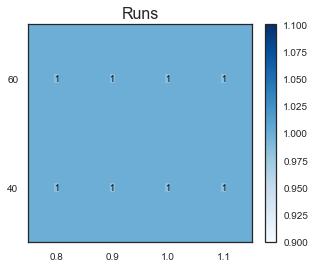

In [39]:
plt.rcParams['figure.figsize'] = 5,4
fig, ax = plt.subplots()
lib.plotHeatMap(df_count,"Runs","Blues",ax=ax,format="d")

### Plot Validation Scores

In [13]:
# Take average between runs
df_mean = df_validation.groupby(["batch","lr","wd"]).mean().reset_index().drop(["run"],axis=1)
df_mean.head()

,batch,lr,wd,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,0,0.0,0.0,0.053122,0.031461,0.021806,0.014992,0.040613,7.041269e-07


In [14]:
df_cider = df_mean.pivot_table(index="batch",columns="wd",values="cider")
df_rouge = df_mean.pivot_table(index="batch",columns="wd",values="rouge")
df_bleu1 = df_mean.pivot_table(index="batch",columns="wd",values="bleu1")
df_bleu2 = df_mean.pivot_table(index="batch",columns="wd",values="bleu2")
df_bleu3 = df_mean.pivot_table(index="batch",columns="wd",values="bleu3")
df_bleu4 = df_mean.pivot_table(index="batch",columns="wd",values="bleu4")
df_cider.head()

wd,0.0
batch,
0,7.041269e-07


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


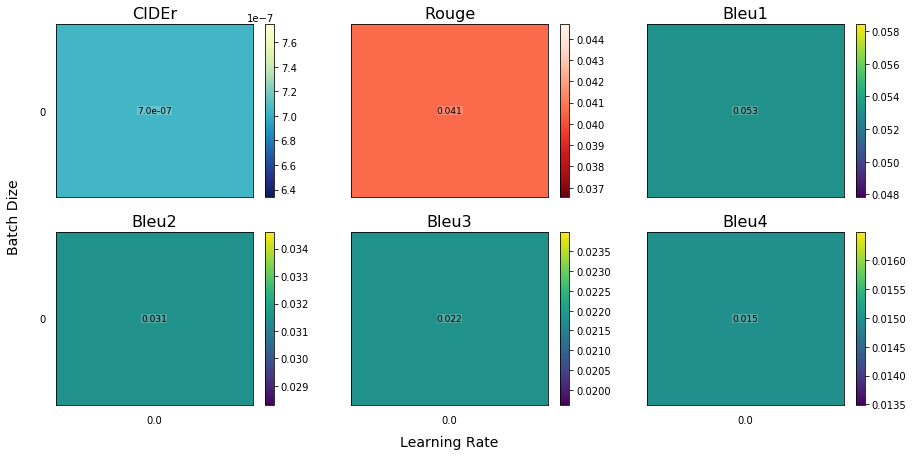

In [15]:
plt.rcParams['figure.figsize'] = 15,7
fig, ax = plt.subplots(2,3,sharex=True,sharey=True)
lib.plotHeatMap(df_cider,"CIDEr","YlGnBu_r",ax=ax[0,0],format=".1e")
lib.plotHeatMap(df_rouge,"Rouge","Reds_r",ax=ax[0,1])
lib.plotHeatMap(df_bleu1,"Bleu1",ax=ax[0,2])
lib.plotHeatMap(df_bleu2,"Bleu2",ax=ax[1,0])
lib.plotHeatMap(df_bleu3,"Bleu3",ax=ax[1,1])
lib.plotHeatMap(df_bleu4,"Bleu4",ax=ax[1,2])
ax[1,1].set_xlabel("Learning Rate",size=14)
#fig.text(0.5, 0.08, 'Learning rate', ha='center',fontsize=14)
fig.text(0.08, 0.5, 'Batch Dize', va='center', rotation='vertical',fontsize=14)
fig.show()

## Loss and epochs heatmap

In [16]:
print df_epochtime.shape
df_epochtime.head()

(4161, 7)


,batch,lr,run,wd,epoch,time,loss
0,0,0.0,0,0.0,1.0,12.439247,8.991751
1,0,0.0,0,0.0,2.0,24.043189,8.986939
2,0,0.0,0,0.0,3.0,35.755322,8.988266
3,0,0.0,0,0.0,4.0,47.502958,8.986410
4,0,0.0,0,0.0,5.0,59.622441,8.981568


In [17]:
# Loss is not always at minimum at last epoch,
# so aggragation min(loss) doesn't show loss at last epoch
# though this approach also may have sence
df_maxepoch = df_epochtime.groupby(["batch","lr","wd","run"]).agg({"epoch":"max","time":"max","loss":"min"})
df_maxepoch.head()

,,,,loss,epoch,time
batch,lr,wd,run,,,
0,0.0,0.0,0,8.336884,271.0,3010.949231


In [18]:
# Make new column with max epoch for each (batch, lr, run) combination
df_maxepoch = df_epochtime.copy()
df_maxepoch["max_epoch"] = df_maxepoch.groupby(["batch","lr","wd","run"])["epoch"].transform(np.max)
#df_maxepoch = df_maxepoch.sort_values(by=["batch","lr","wd","run"],ascending=True)
df_maxepoch.head()

,batch,lr,run,wd,epoch,time,loss,max_epoch
0,0,0.0,0,0.0,1.0,12.439247,8.991751,271.0
1,0,0.0,0,0.0,2.0,24.043189,8.986939,271.0
2,0,0.0,0,0.0,3.0,35.755322,8.988266,271.0
3,0,0.0,0,0.0,4.0,47.502958,8.986410,271.0
4,0,0.0,0,0.0,5.0,59.622441,8.981568,271.0


In [19]:
df_maxepoch = df_maxepoch[df_maxepoch["max_epoch"] == df_maxepoch["epoch"]]
df_maxepoch.head()

,batch,lr,run,wd,epoch,time,loss,max_epoch
2598,0,0.0,0,0.0,271.0,3009.702852,8.489056,271.0
2869,0,0.0,0,0.0,271.0,3001.001735,8.484324,271.0


In [20]:
# Take average between runs
df_mean = df_maxepoch.groupby(["lr","wd"]).mean().reset_index().drop(["run","max_epoch","time"],axis=1)
df_mean.head()

,lr,wd,batch,epoch,loss
0,0.0,0.0,0,271.0,8.48669


In [21]:
loss_df = df_mean[['lr','wd','loss']]
epoch_df = df_mean[['lr','wd','epoch']]

In [22]:
loss_T = loss_df.pivot_table(index="lr",columns="wd",values="loss")
epoch_T = epoch_df.pivot_table(index="lr",columns="wd",values="epoch")

In [23]:
# Create custom colormap
colors= [u'#24368Eff',
         u'#5BBEC0ff',
         u'#F4FAC4ff']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)

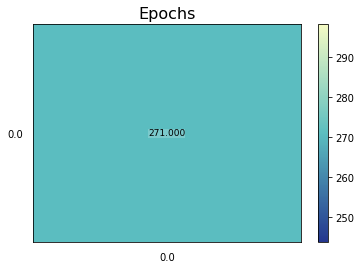

In [24]:
plt.rcParams['figure.figsize'] = 6,4
lib.plotHeatMap(epoch_T,"Epochs",cmap)

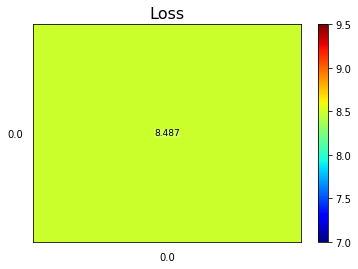

In [25]:
lib.plotHeatMap(loss_T,"Loss","jet",zrange=(7,9.5))

## Plot Loss graphs for each BS x LR combinations

In [26]:
df_epochtime.head()

,batch,lr,run,wd,epoch,time,loss
0,0,0.0,0,0.0,1.0,12.439247,8.991751
1,0,0.0,0,0.0,2.0,24.043189,8.986939
2,0,0.0,0,0.0,3.0,35.755322,8.988266
3,0,0.0,0,0.0,4.0,47.502958,8.986410
4,0,0.0,0,0.0,5.0,59.622441,8.981568


In [27]:
# Take average between runs
df_mean_epo = df_epochtime.groupby(["lr","wd","epoch"]).mean().reset_index().drop(["run"],axis=1)
#df_mean_epo[["epoch"]] = df_mean_epo[["epoch"]].astype(int)
#print df_mean_epo.dtypes
#print df_mean_epo["wd"].values
df_mean_epo.head()

,lr,wd,epoch,batch,time,loss
0,0.0,0.0,1.0,0,11.826146,8.990340
1,0.0,0.0,2.0,0,22.981028,8.987770
2,0.0,0.0,3.0,0,34.248542,8.983230
3,0.0,0.0,4.0,0,45.574380,8.977998
4,0.0,0.0,5.0,0,56.948229,8.972036


In [28]:
df_mean_epo = df_mean_epo.sort_values(by=["lr"],ascending=False)
df_mean_epo = df_mean_epo.sort_values(by=["wd","epoch"],ascending=True)
print df_mean_epo["wd"].unique()
#print df_mean_epo["wd"].values
df_mean_epo.head(5)

[0.]


,lr,wd,epoch,batch,time,loss
0,0.0,0.0,1.0,0,11.826146,8.990340
1,0.0,0.0,2.0,0,22.981028,8.987770
2,0.0,0.0,3.0,0,34.248542,8.983230
3,0.0,0.0,4.0,0,45.574380,8.977998
4,0.0,0.0,5.0,0,56.948229,8.972036


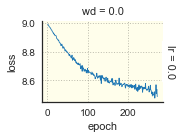

In [29]:
# Plot using Seaborn FacetGrid
# Set Seaborn global parameters
sns.set(font_scale=1)
#sns.set_style("white",{'axes.grid': True, 'grid.color': (0,0,0),'grid.linestyle':u':'})
sns.set_style("white")
#print sns.axes_style()

# Plot using "tab10" matplotlib colormap

# major_xticks = np.arange(0,176,50)
# minor_xticks = np.arange(0,176,25)
# major_yticks = np.arange(5,8.1,1)
# minor_yticks = np.arange(5,8.1,0.5)
with sns.color_palette("tab10"):
    fg = sns.FacetGrid(df_mean_epo,row="lr",col="wd",
                         row_order=df_mean_epo["lr"].unique(),
                         size=2.1,aspect=1.2,
                         #xlim=(0,176),
                         #ylim=(5,8),
                         margin_titles=True,
                         subplot_kws={"facecolor":"#FFFEEB"})
    
    fg.map(plt.plot,"epoch","loss",ls="-",linewidth=.8)
    
    #print "FacetGrid:",fg.__dict__.keys()
    #print fg.axes.shape, fg.axes.size
    #axes = fg.axes.reshape(fg.axes.size)    
    for ax_arr in np.nditer(fg.axes,flags=["refs_ok"]):
        ax = ax_arr.item()
#         ax.set_xticks(major_xticks)
#         ax.set_yticks(major_yticks)
#         ax.set_xticks(minor_xticks, minor=True)        
#         ax.set_yticks(minor_yticks, minor=True)
        ax.grid(which="major",ls=":",alpha=0.25, color="black")
        ax.grid(which="minor",ls=":",alpha=0.15, color="black")

plt.show()